#Import necessary libraries

In [2]:
import inspect
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import VimeoVideo
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

#Load dataset

In [4]:
df = pd.read_csv("/content/drive/MyDrive/september_2018_sensor_data_archive.csv")
df.head()

,timestamp,P2
0,2018-09-01 00:00:26.722,19.30
1,2018-09-01 00:00:43.434,16.90
2,2018-09-01 00:01:19.344,16.10
3,2018-09-01 00:01:26.343,10.83
4,2018-09-01 00:01:29.906,18.47


#Prepare Data

In [6]:
def wrangle(df,resample_rule="1H"):
    # Convert the "timestamp" column to a DatetimeIndex
    df["timestamp"] = pd.to_datetime(df["timestamp"], infer_datetime_format=True)
    df.set_index("timestamp", inplace=True)

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

    # Remove outliers
    df = df[df["P2"] < 500]

    # Resample to 1hr window
    y = df["P2"].resample(resample_rule).mean().fillna(method='ffill')

    return y

In [7]:
# Use wrangle function to read the data
y = wrangle(df,resample_rule="1H")
y.head()

timestamp
2018-09-01 03:00:00+03:00    15.858454
2018-09-01 04:00:00+03:00    13.275321
2018-09-01 05:00:00+03:00    11.583333
2018-09-01 06:00:00+03:00    11.627500
2018-09-01 07:00:00+03:00    13.981279
Freq: H, Name: P2, dtype: float64

# Explore

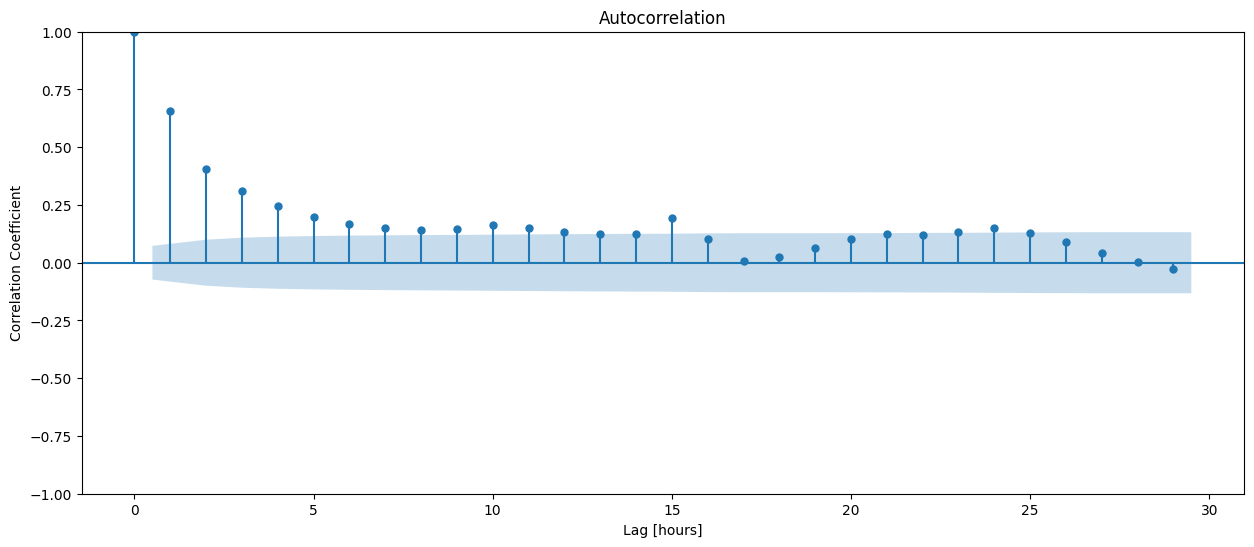

In [8]:
#Create an ACF plot for the data in y. 
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

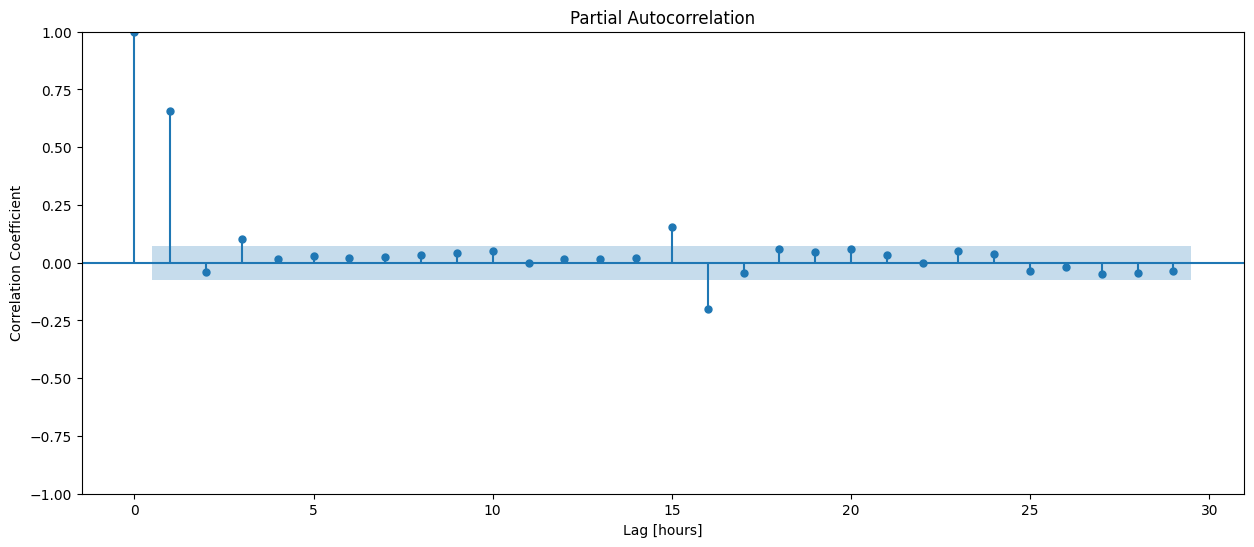

In [10]:
#Create an PACF plot for the data in y
fig,ax=plt.subplots(figsize=(15, 6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

#Split

In [63]:
# Split y into training and test sets. The first 95% of the data should be in your training set.
cutoff_test = int(len(y)*0.95)

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

In [53]:
y_train = y.loc["2018-9-1 00:00:00+03:00":"2018-9-30 23:00:00+03:00"]
y_test = y.loc["2018-10-1 00:00:00+03:00":"2018-10-01 23:00:00+03:00"]

#Build Model

##Baseline

In [64]:
# Calculate the baseline mean absolute error for the model.
y_train_mean=y_train.mean()
y_pred_baseline = [y_train.mean()]*len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 7.26
Baseline MAE: 3.08


## Iterate

In [65]:
#Create ranges for possible  𝑝 and  𝑞 values. 
#p_params should range between 0 and 25, by steps of 8. q_params should range between 0 and 3 by steps of 1.
p_params = range(0,25,8)
q_params = range(0,3,1)

### Grid search

In [74]:
# Create dictionary to store MAEs
mae_grid = dict()

# Specify arguments for the ARIMA model
arima_args = {'enforce_stationarity': False, 'enforce_invertibility': False}

# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train, order=order, **arima_args).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train, y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

In [67]:
#Organize all the MAE's from above in a DataFrame names mae_df
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)
#Each row represents a possible value for  𝑞 and each column represents a possible value for  𝑝

,0,8,16,24
0,3.0737,1.8597,1.8612,1.8339
1,2.2509,1.8606,1.8592,1.8524
2,2.0367,1.8465,1.8649,1.8561


 Create heatmap of the values in `mae_grid`

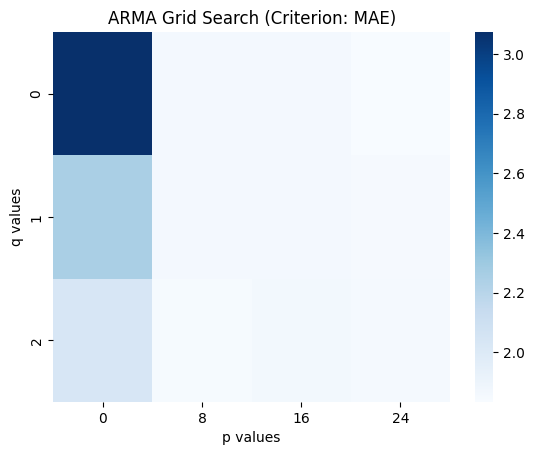

In [68]:
sns.heatmap(mae_df,cmap="Blues")
plt.xlabel("p values")
plt.ylabel("q values")
plt.title("ARMA Grid Search (Criterion: MAE)");

## Residual Analysis

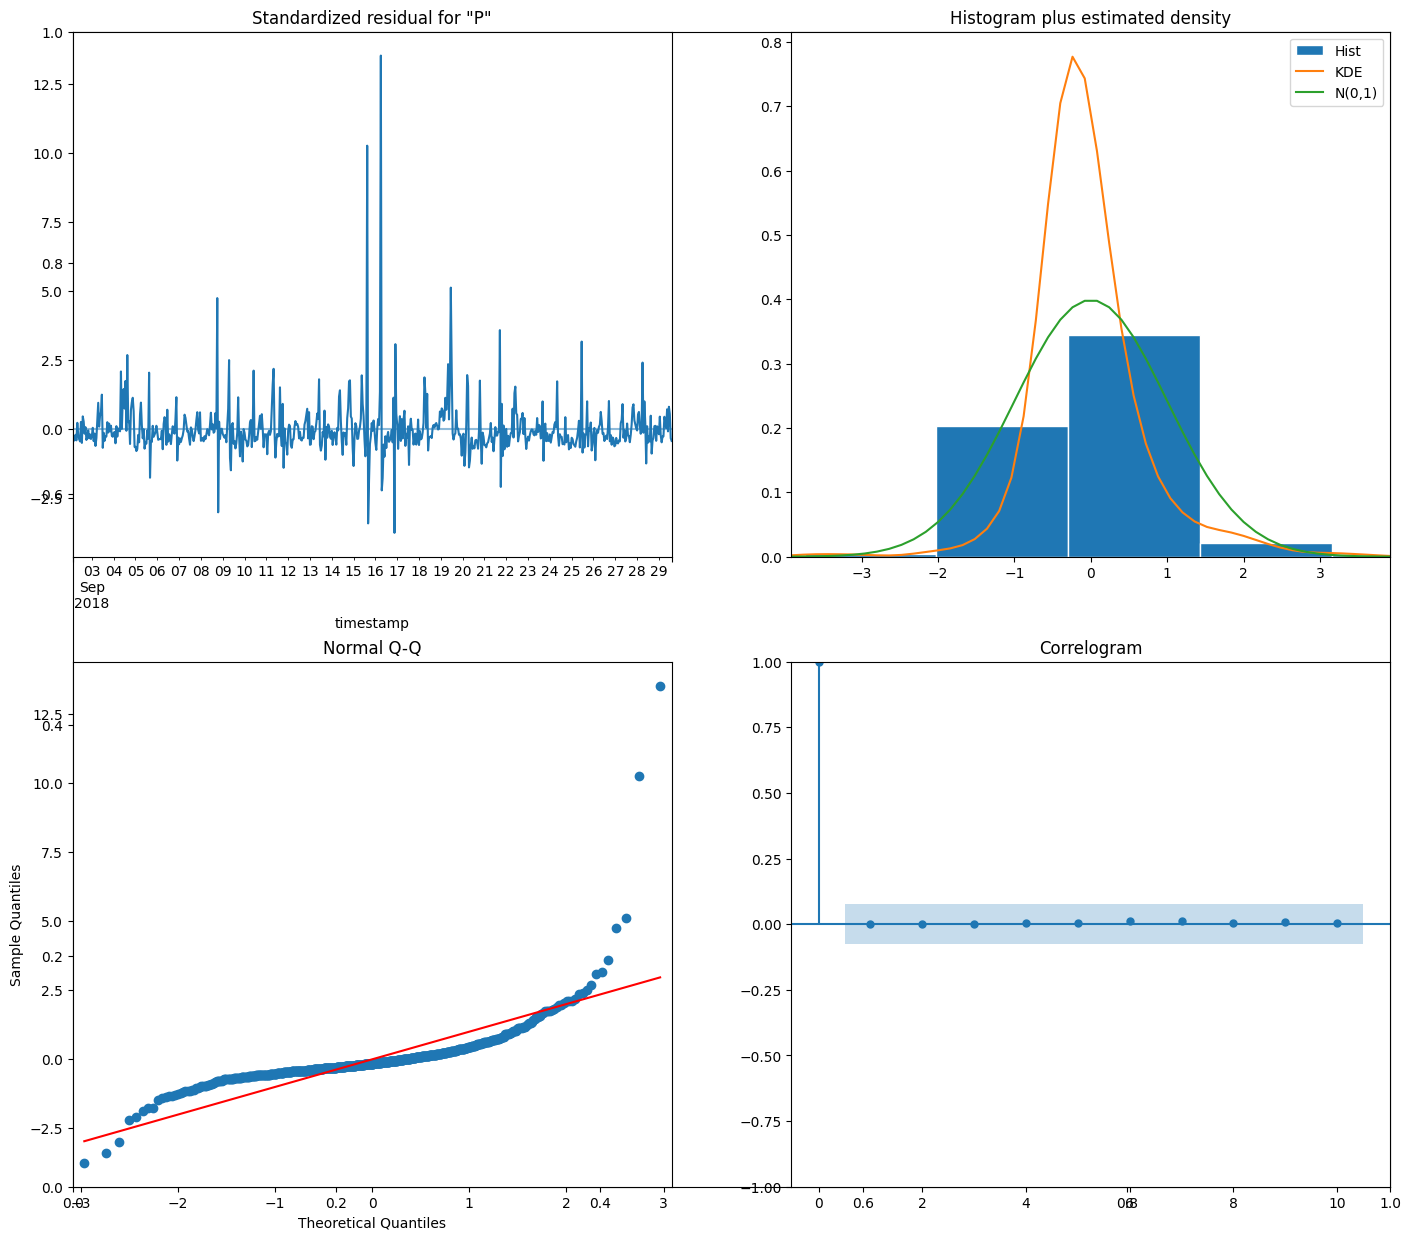

In [69]:
fig, ax = plt.subplots(figsize=(17, 15))
model.plot_diagnostics(fig=fig);

1. The residuals should not show any patterns or trends in their values over time.

2. The residuals  have a constant variance over time.

3. The residuals  follow a normal distribution. 

4. Residuals don't show any autocorrelation


## Evaluate

###walk-forward validation 

In [74]:
# Perform walk-forward validation for my model for the entire test set y_test
y_pred_wfv = pd.Series(dtype='float64')
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order=(8, 0, 2)).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history = pd.concat([history, y_test[next_pred.index]])

In [74]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 0.91


#Communicate Results

In [73]:
#Generate in-sample predictions for a model
df_predictions = pd.DataFrame(
{ "y_test":y_test,
 "y_pred_wfv":y_pred_wfv
    
})
# Create a line plot
fig = px.line(df_predictions,labels={"value":"PM2.5"})
fig.show()